In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import heapq

def optics_clustering(data, min_samples=5, eps=np.inf):
    n = len(data)
    reachability = np.full(n, np.inf)
    processed = np.zeros(n, dtype=bool)
    ordering = []
    neighbors_dict = {}

    distances = cdist(data, data)

    def get_neighbors(point_idx):
        if point_idx not in neighbors_dict:
            neighbors_dict[point_idx] = np.where(distances[point_idx] <= eps)[0]
        return neighbors_dict[point_idx]

    def update_reachability(seeds, center_idx, neighbors):
        core_dist = np.sort(distances[center_idx])[min_samples]
        if core_dist == 0 or np.isinf(core_dist):
            return

        for neighbor in neighbors:
            if not processed[neighbor]:
                new_reachability = max(core_dist, distances[center_idx, neighbor])
                if new_reachability < reachability[neighbor]:
                    reachability[neighbor] = new_reachability
                    heapq.heappush(seeds, (new_reachability, neighbor))

    def expand_cluster(start_idx):
        seeds = []
        reachability[start_idx] = 0
        ordering.append(start_idx)
        processed[start_idx] = True

        neighbors = get_neighbors(start_idx)
        if len(neighbors) >= min_samples:
            update_reachability(seeds, start_idx, neighbors)

        while seeds:
            _, new_point = heapq.heappop(seeds)
            if not processed[new_point]:
                processed[new_point] = True
                ordering.append(new_point)
                new_neighbors = get_neighbors(new_point)
                if len(new_neighbors) >= min_samples:
                    update_reachability(seeds, new_point, new_neighbors)

    for i in range(n):
        if not processed[i]:
            expand_cluster(i)

    clusters = np.full(n, -1)
    cluster_id = 0
    reachability_threshold = np.percentile(reachability, 98)

    for i in range(1, len(ordering)):
        if reachability[ordering[i]] > reachability_threshold:
            cluster_id += 1
        clusters[ordering[i]] = cluster_id

    return clusters

def run(dataset, min_samples, step):
    
    df = pd.read_csv(dataset)

    unique_generations = sorted(df["generation"].unique())

    selected_generations = [unique_generations[0]] + unique_generations[step-1::step] + [unique_generations[-1]]

    first_gen_data = df[df["generation"] == unique_generations[0]].drop(columns=["generation", "id"]).values
    pca = PCA(n_components=2)
    pca.fit(first_gen_data)

    for gen in selected_generations:
        pop_data = df[df["generation"] == gen].drop(columns=["generation", "id"]).values
        reduced_data = pca.transform(pop_data)

        max_distance = np.max(cdist(reduced_data, reduced_data))
        eps = 0.25 * max_distance

        clusters = optics_clustering(pop_data, min_samples=min_samples, eps=eps)

        plt.figure(figsize=(6, 6))
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
        plt.title(f"Generation {gen} - Improved Custom OPTICS Clustering")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.colorbar(label="Cluster Label")
        plt.show()

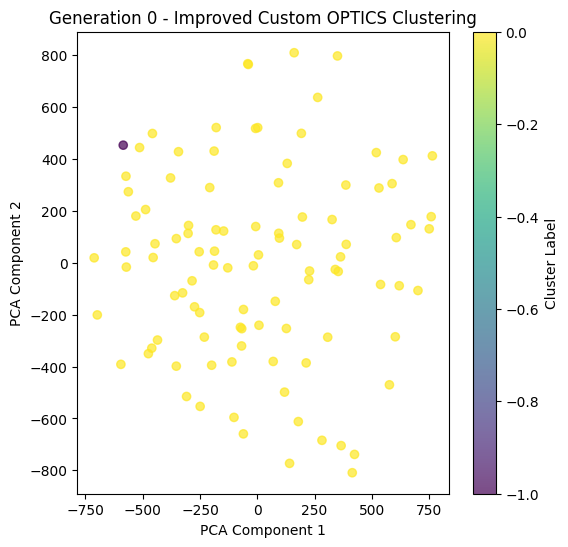

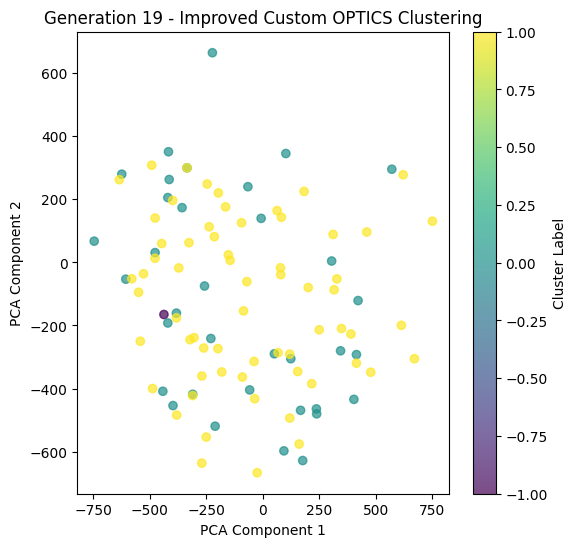

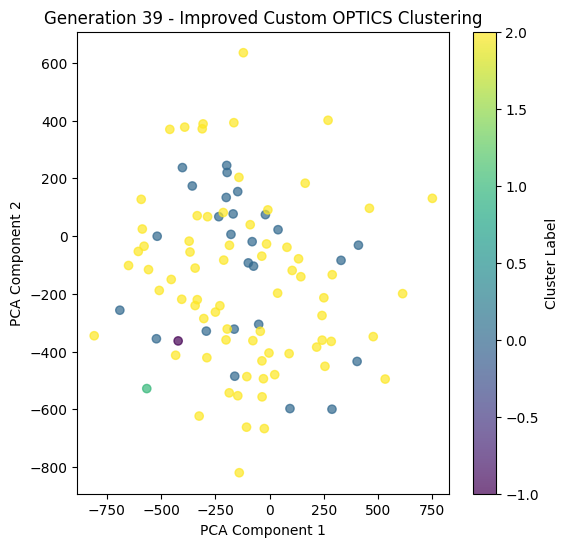

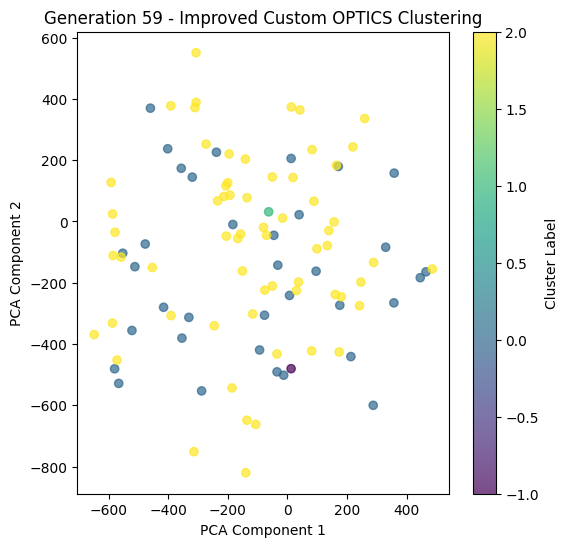

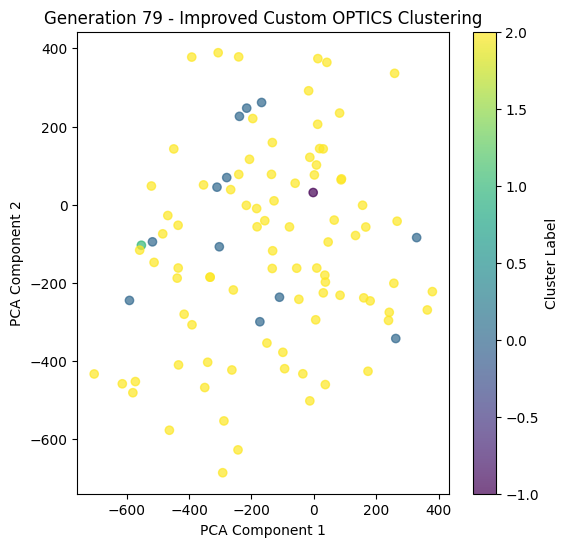

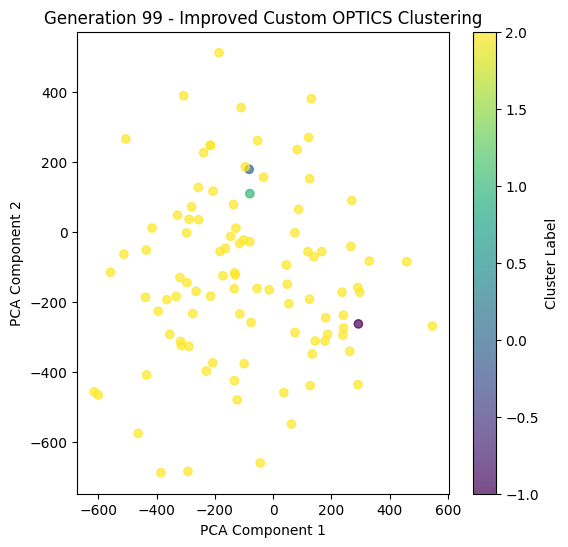

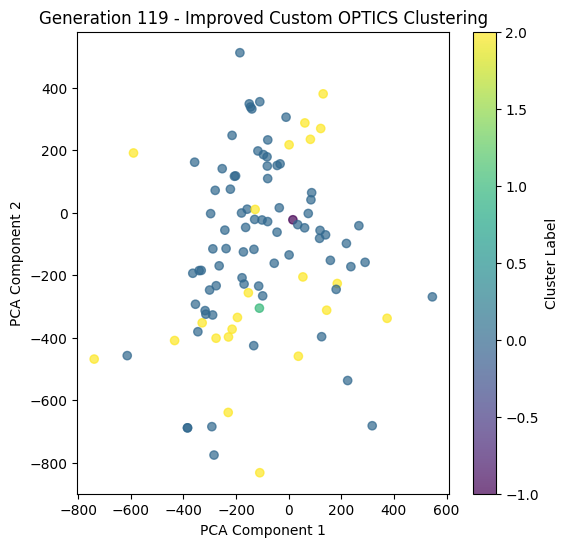

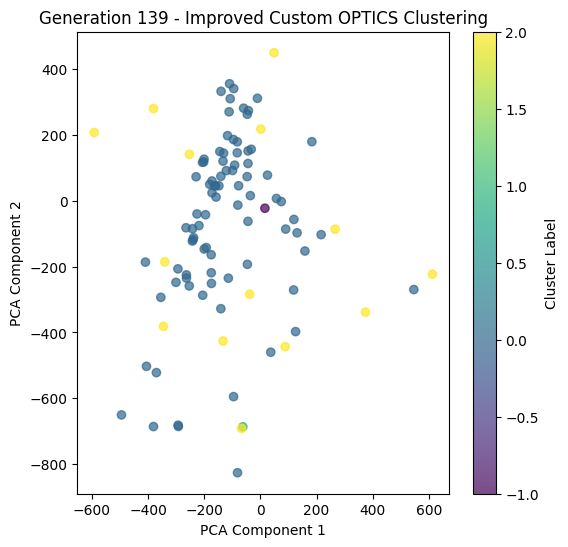

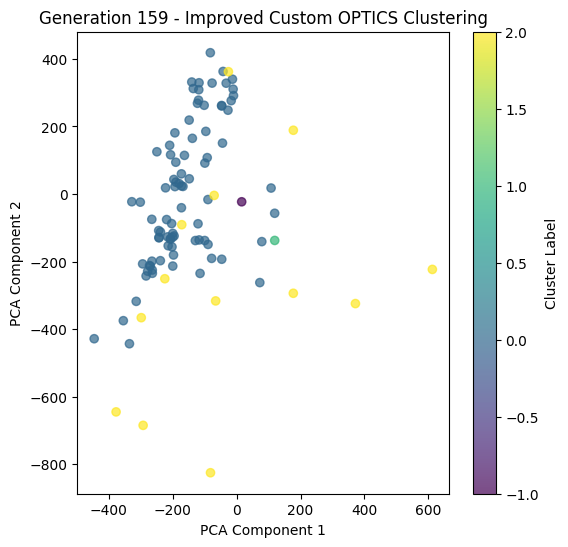

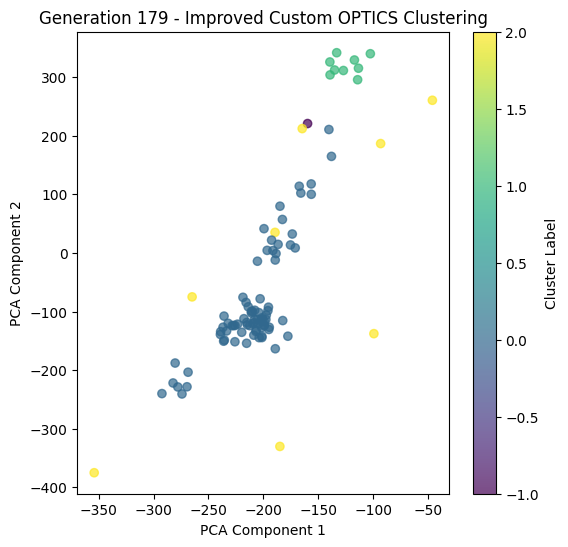

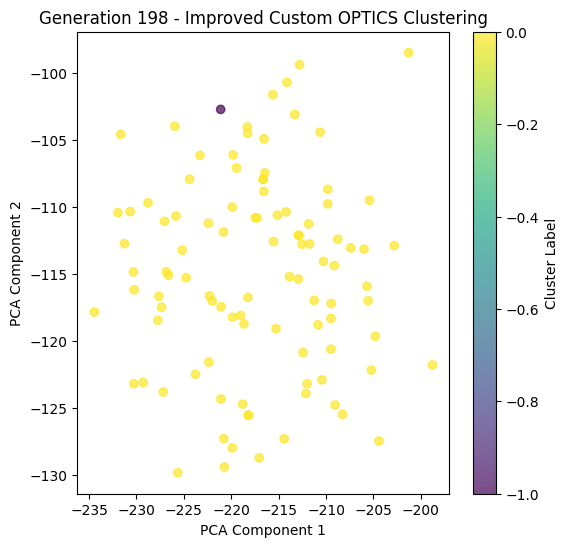

In [22]:
run("population_log_DE.csv", 3, 20)

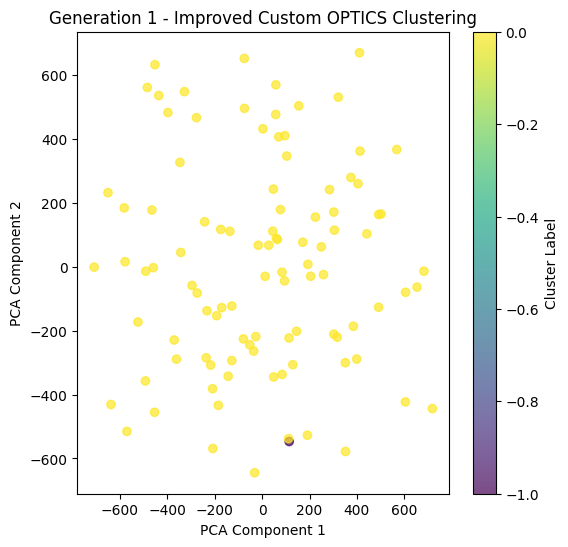

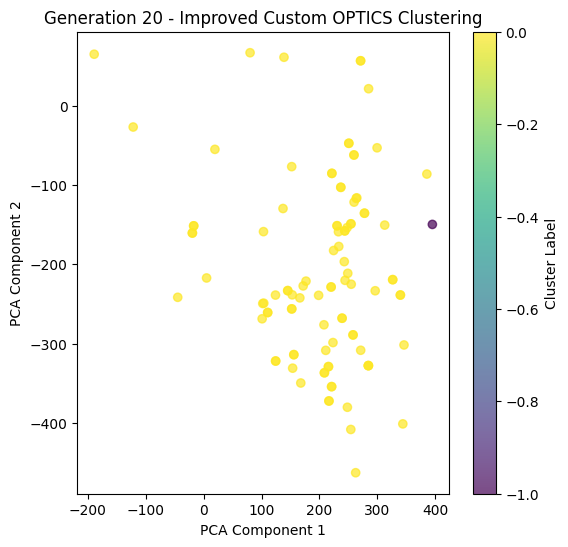

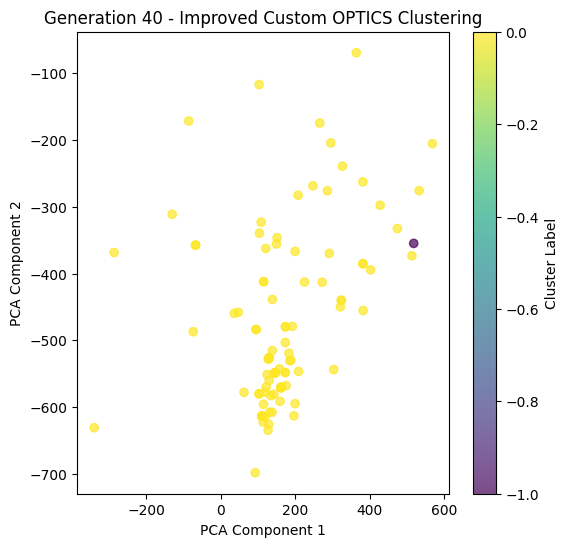

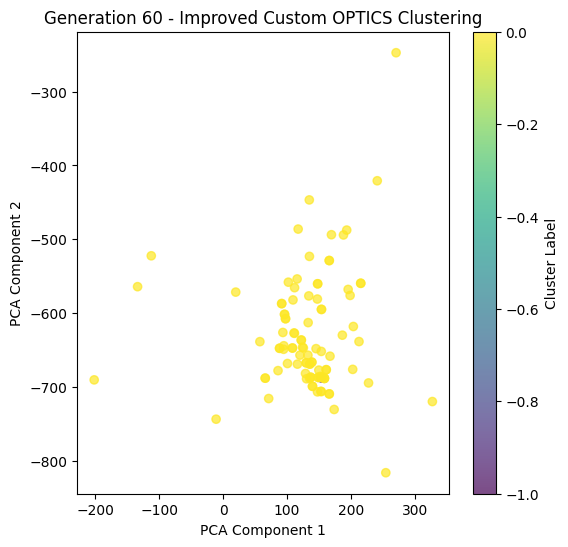

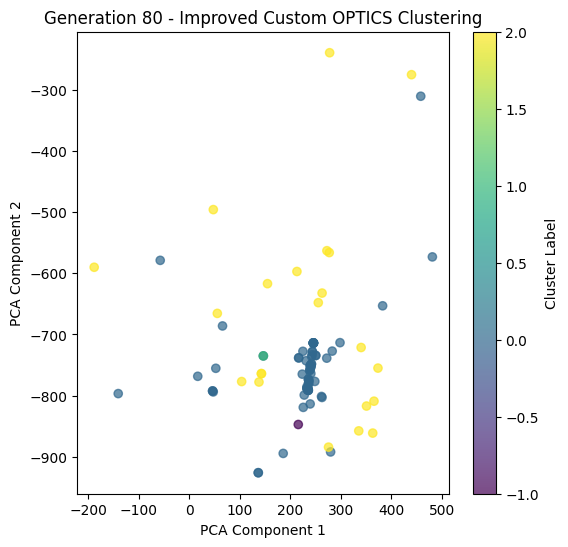

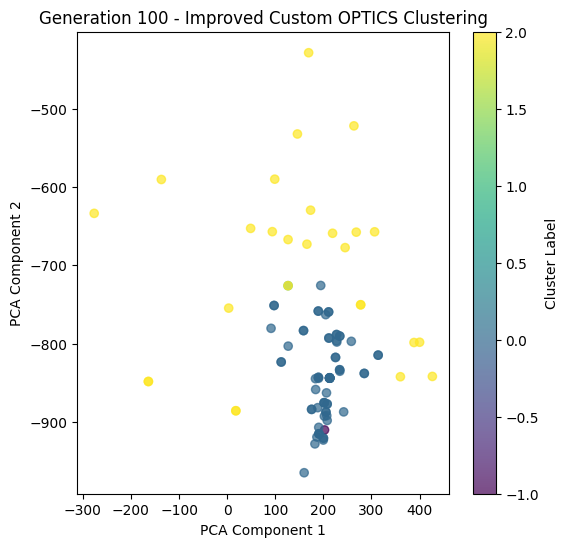

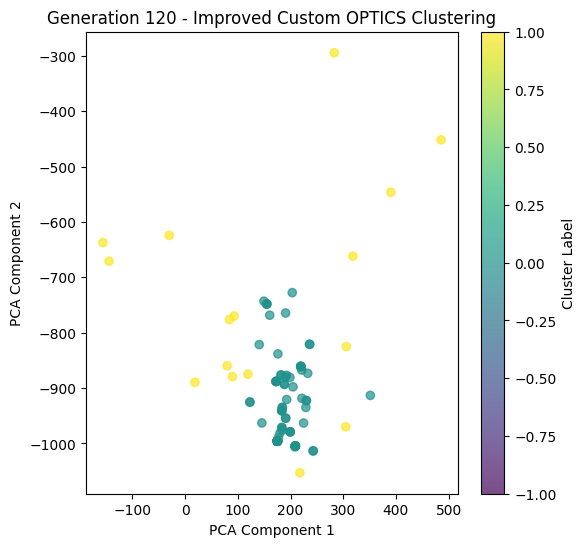

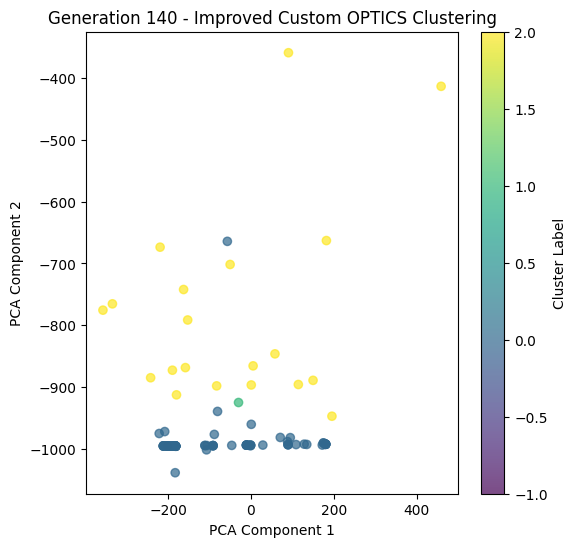

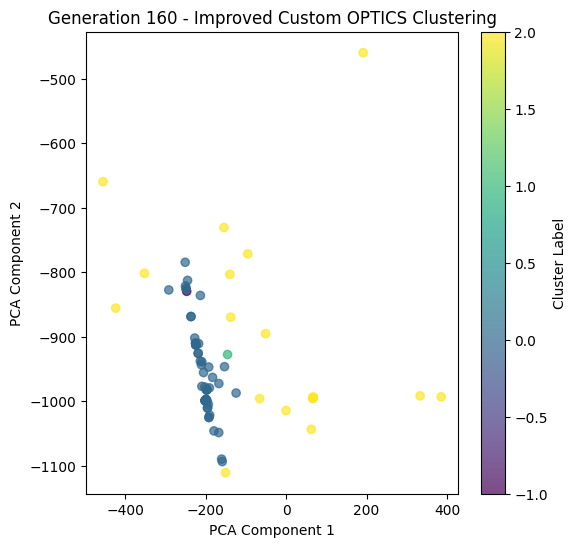

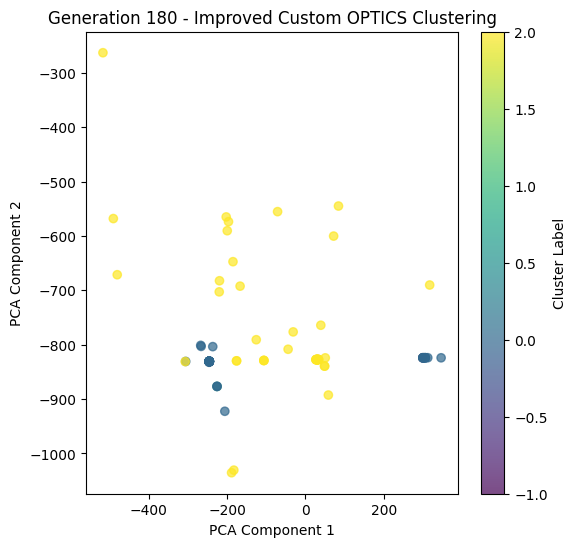

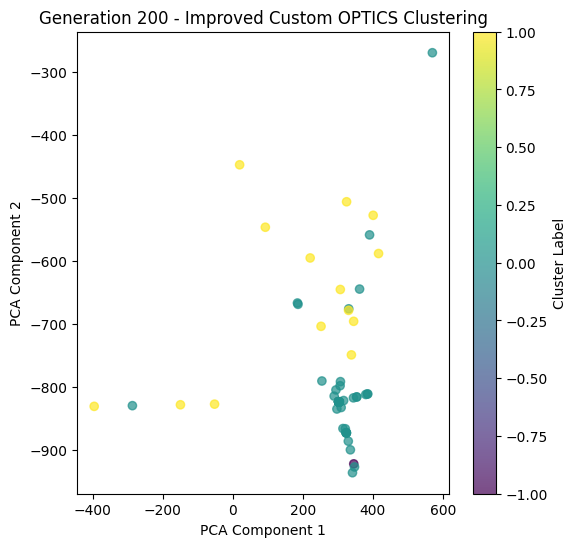

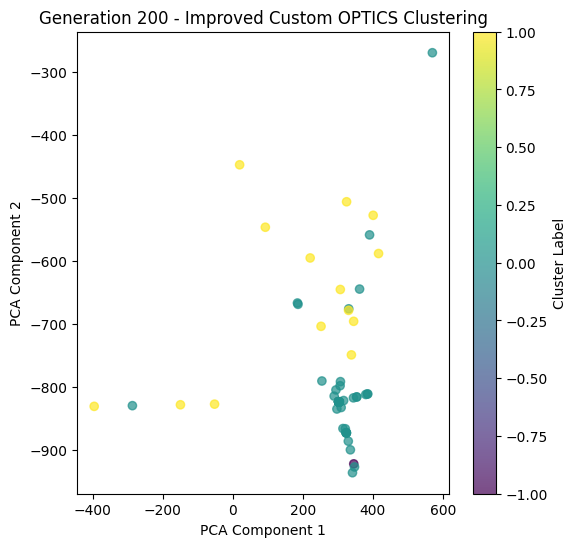

In [8]:
run("population_log_GA.csv", 5, 20)